# Fabey Perot in meep(AB)

## first of all load the library

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

## 定義參數

In [2]:
fmin = 0.05 #300THz
fmax = 0.265 #600THz
nf = 1000 
fcen = (fmin + fmax)/2
df = fmax - fmin
#dfp = 1/2
fre = np.linspace(fmin,fmax,nf)
omega = 2 * np.pi * fre

In [3]:
dpml = 1

dA = 0.2
dB = 0.3
epsilonA = 80
epsilonB = 20

NAB = 15

sz = 2*dpml+16

resolution = 100 # pixels/μm

cell_size = mp.Vector3(z=sz)

pml_layers = [mp.PML(dpml)]

source_z=-sz/2+dpml
flux_reg_z=sz/2-dpml

## geometry AB and BA

In [4]:
def BlockAB(N, center):
    geometry = []
    for i in range(N):
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA/2),
                     material=mp.Medium(epsilon=epsilonA)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA + dB/2),
                     material=mp.Medium(epsilon=epsilonB)))
    geometry = geometry.tolist()
    return geometry

In [5]:
def BlockBA(N, center):
    geometry = []
    for i in range(N):
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB/2),
                     material=mp.Medium(epsilon=epsilonB)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB + dA/2),
                     material=mp.Medium(epsilon=epsilonA)))
    geometry = geometry.tolist()
    return geometry

In [6]:
#geometry = sum([BlockAB(10,-10*(dA+dB)/2),BlockBA(10,10*(dA+dB)/2)],[])

## Sources set up

In [7]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ex,
                     center=mp.Vector3(z=source_z),
                     size=mp.Vector3())]

## Simulation 真空

In [8]:
sim_vac = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    dimensions=1,
                    sources=sources)
refl_fr = mp.FluxRegion(center=mp.Vector3(z=-8))
refl = sim_vac.add_flux(fcen, df,nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z=8))
tran = sim_vac.add_flux(fcen, df, nf, tran_fr)
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,
                                                            mp.Vector3(z=0),1e-3))
empty_flux = mp.get_fluxes(tran)
empty_data = sim_vac.get_flux_data(refl)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
time for set_epsilon = 0.00105906 s
-----------
field decay(t = 50.005): 0.2500056553228205 / 0.2500056553228205 = 1.0
field decay(t = 100.01): 3.155121128080814e-08 / 0.2500056553228205 = 1.2620199027125026e-07
run 0 finished at t = 100.01 (20002 timesteps)


## Simulation 介質AB

In [9]:
sim = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=1,
                    geometry=BlockAB(NAB,0))
tran = sim.add_flux(fcen, df, nf, tran_fr)
refl = sim.add_flux(fcen, df, nf, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex,
                                                        mp.Vector3(z=0), 1e-3))

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000152826 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
     block, center = (0,0,-3.65)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (80,80,80)
     block, center = (0,0,-3.4)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (20,20,20)
     block, center = (0,0,-3.15)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (80,80,80)
     block, center = (0,0,-2.9)
          size (1e+20,1e+20,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (20,20,20)
     block, center = (0,0,-2.65)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (80,80,80)
    

In [10]:
wvls = np.empty(nf)
R = np.empty(nf)
T = np.empty(nf)
for i in range(nf):
        wvls[i] = 1/freqs[i]*2*np.pi*3*10
        R[i] = -refl_flux[i]/empty_flux[i]
        T[i] = tran_flux[i]/empty_flux[i] 

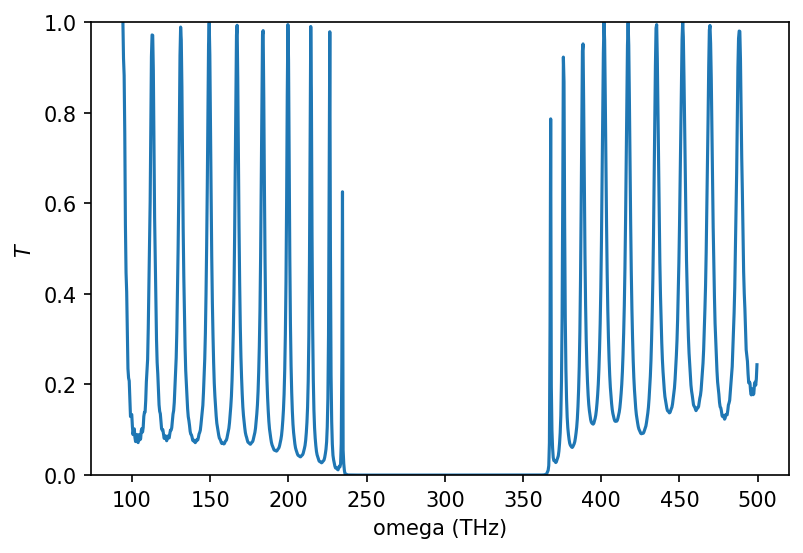

In [12]:
plt.figure(dpi=150)#解析度
plt.plot(omega*300,T,'-',label='$T_{nur}$')#x軸omega y軸T
#plt.plot(omega/2/np.pi,R,'.',label='$T_{nur}$')
plt.xlabel("omega (THz)")
plt.ylabel("$T$")
#plt.xlim([fmin,fmax])
plt.ylim([0,1])
plt.savefig('15AB(250-350THz).png')
plt.show()